https://neptune.ai/blog/web-scraping-and-knowledge-graphs-machine-learning

In [4]:

import wikipediaapi  
import pandas as pd
import concurrent.futures
from tqdm import tqdm


In [6]:
def scrape_wikipedia(name_topic, verbose=True):
   def link_to_wikipedia(link):
       try:
           page = api_wikipedia.page(link)
           if page.exists():
               return {'page': link, 'text': page.text, 'link': page.fullurl, 'categories': list(page.categories.keys())}
       except:
           return None
      
   api_wikipedia = wikipediaapi.Wikipedia(language='en',user_agent="Mozilla/5.0 (X11; Linux i686; rv:109.0) Gecko/20100101 Firefox/121.0", extract_format=wikipediaapi.ExtractFormat.WIKI)
   name_of_page = api_wikipedia.page(name_topic)
   if not name_of_page.exists():
       print('Page {} is not present'.format(name_of_page))
       return
  
   links_to_page = list(name_of_page.links.keys())
   procceed = tqdm(desc='Scraped links', unit='', total=len(links_to_page)) if verbose else None
   origin = [{'page': name_topic, 'text': name_of_page.text, 'link': name_of_page.fullurl, 'categories': list(name_of_page.categories.keys())}]
  
   with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
       links_future = {executor.submit(link_to_wikipedia, link): link for link in links_to_page}
       for future in concurrent.futures.as_completed(links_future):
           info = future.result()
           origin.append(info) if info else None
           procceed.update(1) if verbose else None
   procceed.close() if verbose else None
  
   namespaces = ('Wikipedia', 'Special', 'Talk', 'LyricWiki', 'File', 'MediaWiki',
                 'Template', 'Help', 'User', 'Category talk', 'Portal talk')
   origin = pd.DataFrame(origin)
   origin = origin[(len(origin['text']) > 20)
                     & ~(origin['page'].str.startswith(namespaces, na=True))]
   origin['categories'] = origin.categories.apply(lambda a: [b[9:] for b in a])

   origin['topic'] = name_topic
   print('Scraped pages', len(origin))
  
   return origin


In [7]:
data_wikipedia = scrape_wikipedia('Artificial_intelligence')

Scraped links: 100%|██████████| 1593/1593 [03:11<00:00,  8.32/s]

Scraped pages 1549


In [8]:
data_wikipedia.to_csv('scraped_data.csv')

Now that we have the data stored as csv we want to create the graph

In [1]:
# download spacy model
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 12.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import spacy
import pandas as pd
import requests
from spacy import displacy
# import en_core_web_sm
 
nlp = spacy.load('en_core_web_sm')
 
from spacy.tokens import Span
from spacy.matcher import Matcher
 
import matplotlib.pyplot as plot
from tqdm import tqdm
import networkx as ntx
import neptune
 
%matplotlib inline


In [17]:
import os
from dotenv import load_dotenv

load_dotenv()

API_TOKEN = os.getenv('NEPTUNE_API_TOKEN')

# FIXME api token isnt laoded correctly but instead truncated
run = neptune.init_run(
    project="7frank/scaping-knowledge-graph",
    api_token=API_TOKEN+"==",
)

https://app.neptune.ai/7frank/scaping-knowledge-graph/e/SCAP-4


In [18]:
# Upload data to Neptune.
run["data"].upload("scraped_data.csv")

In [20]:

data = pd.read_csv('scraped_data.csv')
data

,Unnamed: 0,page,text,link,categories,topic
0,0,Artificial_intelligence,Artificial intelligence (AI) is the intelligen...,https://en.wikipedia.org/wiki/Artificial_intel...,"['All articles needing additional references',...",Artificial_intelligence
1,1,2023 AI Safety Summit,The AI Safety Summit was an international conf...,https://en.wikipedia.org/wiki/AI_Safety_Summit,"['2023 conferences', 'All Wikipedia articles i...",Artificial_intelligence
2,2,2001: A Space Odyssey (film),2001: A Space Odyssey is a 1968 epic science f...,https://en.wikipedia.org/wiki/2001:_A_Space_Od...,"['1960s American films', '1960s British films'...",Artificial_intelligence
3,3,3D optical data storage,3D optical data storage is any form of optical...,https://en.wikipedia.org/wiki/3D_optical_data_...,"['All articles lacking in-text citations', 'Al...",Artificial_intelligence
4,4,A* search algorithm,"A* (pronounced ""A-star"") is a graph traversal ...",https://en.wikipedia.org/wiki/A*_search_algorithm,"['All articles with unsourced statements', 'Ar...",Artificial_intelligence
...,...,...,...,...,...,...
1544,1579,Category:Wikipedia articles needing clarificat...,This category combines all Wikipedia articles ...,https://en.wikipedia.org/wiki/Category:Wikiped...,"['CatAutoTOC generates standard Category TOC',...",Artificial_intelligence
1545,1580,Portal:Computer programming,NaN,https://en.wikipedia.org/wiki/Portal:Computer_...,"['All portals', 'All portals with triaged subp...",Artificial_intelligence
1546,1581,Portal:Philosophy,NaN,https://en.wikipedia.org/wiki/Portal:Philosophy,"['All portals', 'All portals with untriaged su...",Artificial_intelligence
1547,1582,Portal:Science,NaN,https://en.wikipedia.org/wiki/Portal:Science,"['All manually maintained portal pages', 'All ...",Artificial_intelligence


Sentence segmentation

The first step of building a knowledge graph is to split the text document or article into sentences. Then we limit our examples to simple sentences with one subject and one object.

In [23]:
# Lets take part of the above extracted article
docu = nlp('''The AbC-19 rapid antibody test is an immunological test for COVID-19 exposure developed by
the UK Rapid Test Consortium and manufactured by Abingdon Health. It uses a lateral flow test to determine
whether a person has IgG antibodies to the SARS-CoV-2 virus that causes COVID-19. The test uses a single
drop of blood obtained from a finger prick and yields results in 20 minutes.\n\nSee also\nCOVID-19 rapid
antigen test''')
 
for tokn in docu:
   print(tokn.text, "---", tokn.dep_)

The --- det
AbC-19 --- amod
rapid --- amod
antibody --- compound
test --- nsubj
is --- ROOT
an --- det
immunological --- amod
test --- attr
for --- prep
COVID-19 --- compound
exposure --- pobj
developed --- acl
by --- agent

 --- dep
the --- det
UK --- compound
Rapid --- compound
Test --- compound
Consortium --- pobj
and --- cc
manufactured --- conj
by --- agent
Abingdon --- compound
Health --- pobj
. --- punct
It --- nsubj
uses --- ROOT
a --- det
lateral --- amod
flow --- compound
test --- dobj
to --- aux
determine --- xcomp

 --- dep
whether --- mark
a --- det
person --- nsubj
has --- ccomp
IgG --- nsubj
antibodies --- conj
to --- prep
the --- det
SARS --- compound
- --- punct
CoV-2 --- compound
virus --- pobj
that --- nsubj
causes --- relcl
COVID-19 --- dobj
. --- punct
The --- det
test --- nsubj
uses --- ROOT
a --- det
single --- amod

 --- dep
drop --- dobj
of --- prep
blood --- pobj
obtained --- acl
from --- prep
a --- det
finger --- compound
prick --- pobj
and --- cc
yields --- 

Download the pre-trained SpaCy model as shown below:

In [21]:
!python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 11.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


The SpaCy pipeline assigns word vectors, context-specific token vectors, part-of-speech tags, dependency parsing, and named entities. By extending SpaCy’s pipeline of annotations you can resolve coreferences (explained below).

Knowledge graphs can be automatically constructed from parts-of-speech and dependency parsing. Extraction of entity pairs from grammatical patterns is fast and scalable to large amounts of text using the NLP library SpaCy.

The following function defines entity pairs as entities/noun chunks with subject-object dependencies connected by a root verb. Other approximations can be used to produce different types of connections. This kind of connection can be referred to as subject-predicate-object triple.

The main idea is to go through a sentence and extract the subject and object, and when they’re encountered. The below function has some of the steps mentioned.
Entity extraction

You can extract a single-word entity from a sentence with the help of parts-of-speech (POS) tags. The nouns and proper nouns will be the entities. 

However, when an entity spans multiple words, POS tags alone aren’t sufficient. We need to parse the dependency tree of the sentence. To build a knowledge graph, the most important things are the nodes and edges between them. 

These nodes are going to be entities that are present in the Wikipedia sentences. Edges are the relationships connecting these entities. We will extract these elements in an unsupervised manner, i.e. we’ll use the grammar of the sentences.

The idea is to go through a sentence and extract the subject and the object as and when they are reconstructed.

In [22]:
def extract_entities(sents):
   # chunk one
   enti_one = ""
   enti_two = ""
  
   dep_prev_token = "" # dependency tag of previous token in sentence
  
   txt_prev_token = "" # previous token in sentence
  
   prefix = ""
   modifier = ""
  
  
  
   for tokn in nlp(sents):
       # chunk two
       ## move to next token if token is punctuation
      
       if tokn.dep_ != "punct":
           #  check if token is compound word or not
           if tokn.dep_ == "compound":
               prefix = tokn.text
               # add the current word to it if the previous word is 'compound’
               if dep_prev_token == "compound":
                   prefix = txt_prev_token + " "+ tokn.text
                  
           # verify if token is modifier or not
           if tokn.dep_.endswith("mod") == True:
               modifier = tokn.text
               # add it to the current word if the previous word is 'compound'
               if dep_prev_token == "compound":
                   modifier = txt_prev_token + " "+ tokn.text
                  
           # chunk3
           if tokn.dep_.find("subj") == True:
               enti_one = modifier +" "+ prefix + " "+ tokn.text
               prefix = ""
               modifier = ""
               dep_prev_token = ""
               txt_prev_token = ""
              
           # chunk4
           if tokn.dep_.find("obj") == True:
               enti_two = modifier +" "+ prefix +" "+ tokn.text
              
           # chunk 5
           # update variable
           dep_prev_token = tokn.dep_
           txt_prev_token = tokn.text
          
   return [enti_one.strip(), enti_two.strip()]

In [24]:
extract_entities("The AbC-19 rapid antibody test is an immunological test for COVID-19 exposure developed by the UK Rapid Test")

['rapid antibody test', 'immunological UK Rapid Test']


Now let’s use the function to extract entity pairs for 800 sentences.

In [25]:
pairs_of_entities = []
for i in tqdm(data['text'][:800]):
   pairs_of_entities.append(extract_entities(i))


100%|██████████| 800/800 [14:42<00:00,  1.10s/it]


In [27]:
# Subject object pairs from sentences
pairs_of_entities[36:42]

[['Such DCAS regulation', 'External Highway Safety'],
 ['External Faith links', 'Computer Faith Sciences'],
 ['Taxonomy Machine Learning Workshop', '12567278 Artificial Intelligence'],
 ['typically Chemical rockets', 'Hierarchical Aeronautics Europe'],
 ['which', 'Power Planetary Aerobots Systems'],
 ['R. B. R. Preferences', '2008 Affect Affect'],
 ['social  that', 'sensitive Internet PhilPapers'],
 ['also Citations Works', 's1071 Affective Computing'],
 ['extreme CNC Farming VAE', 'Agricultural Wikimedia Commons'],
 ['ITAC Canadian AI He', 'Royal Canada'],
 ['Notable engineering people', 'Official Alan Turing Institute'],
 ['early AlexNet paper', '120,000 Google Scholar'],
 ['neural Turing he', 'paper']]

Relations extraction

With entity extraction, half the job is done. To build a knowledge graph, we need to connect the nodes (entities). These edges are relations between pairs of nodes. The function below is capable of capturing such predicates from these sentences. I used spaCy’s rule-based matching. The pattern defined in the function tries to find the ROOT word or the main verb in the sentence. 

In [34]:
def obtain_relation(sent):
  
   doc = nlp(sent)
  
   matcher = Matcher(nlp.vocab)
  
   pattern = [{'DEP':'ROOT'},
           {'DEP':'prep','OP':"?"},
           {'DEP':'agent','OP':"?"}, 
           {'POS':'ADJ','OP':"?"}]
  
   matcher.add("matching_1", [pattern])
  
   matcher = matcher(doc)
   h = len(matcher) - 1
  
   span = doc[matcher[h][1]:matcher[h][2]]
  
   return span.text

The pattern which is written above tries to find the root word in sentences. Once it is recognized then it checks if a preposition or an agent word follows it. If it’s a yes then it’s added to the root word.

In [35]:
relations = [obtain_relation(j) for j in tqdm(data['text'][:800])]

  0%|          | 0/800 [00:00<?, ?it/s]

100%|██████████| 800/800 [09:19<00:00,  1.43it/s]


Building a knowledge graph

Now we can finally create a knowledge graph from the extracted entities 

Let’s draw the network using the networkX library. We’ll create a directed multigraph network with node size in proportion to the degree of centrality. In other words, the relations between any connected node pair are not two-way. They’re only from one node to another.

In [36]:
# subject extraction
source = [j[0] for j in pairs_of_entities]

#object extraction
target = [k[1] for k in pairs_of_entities]

data_kgf = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [38]:
json_file_path = 'data_kgf.json'

In [ ]:
# Convert the DataFrame to JSON and save it to a file
data_kgf.to_json(json_file_path, orient='records', lines=True)

In [39]:

# Check if the file exists
if os.path.exists(json_file_path):
    # Load the DataFrame from the JSON file
    data_kgf = pd.read_json(json_file_path, orient='records', lines=True)
else:
    print("File not found.")


    We are using the networkx library to create a network from the data frame.
    Here nodes will be represented as entities and edges represent the relationship between nodes


In [40]:
# Create DG from the dataframe
graph = ntx.from_pandas_edgelist(data_kgf, "source", "target",
                         edge_attr=True, create_using=ntx.MultiDiGraph())

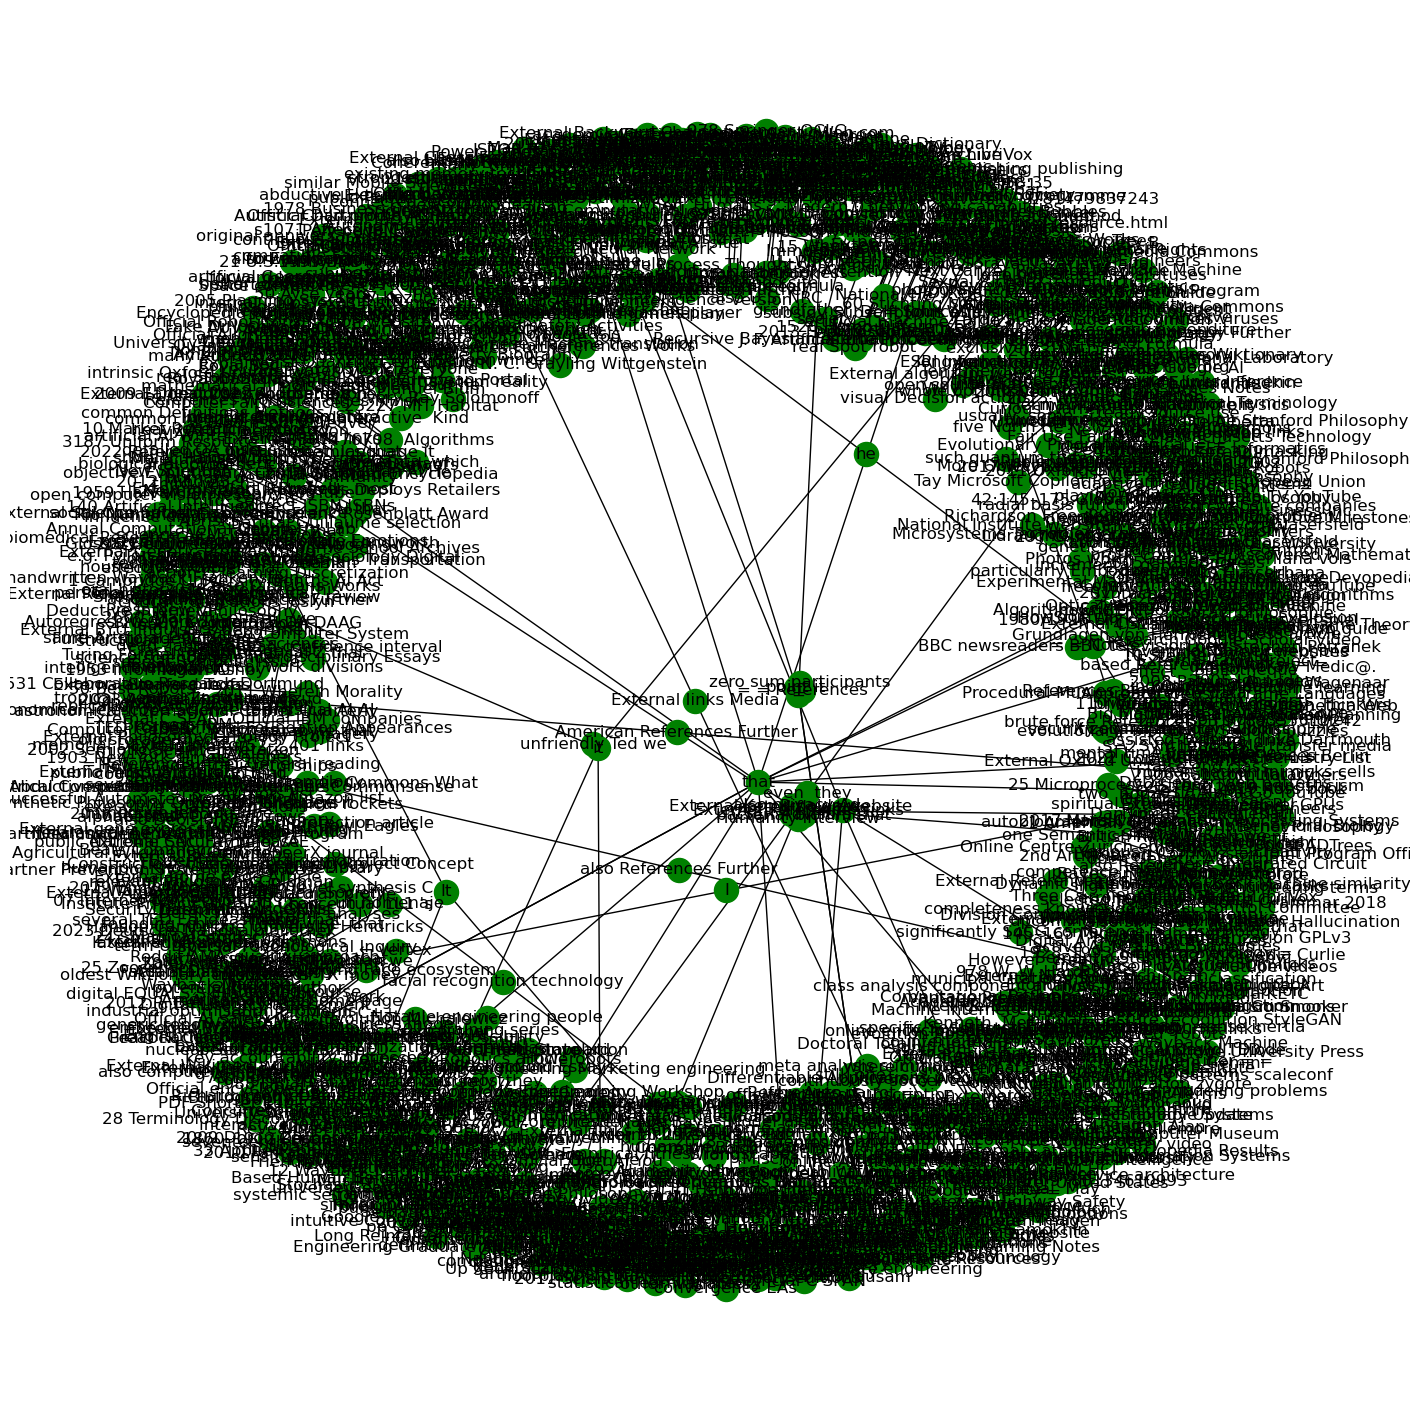

In [41]:
# plotting the network
plot.figure(figsize=(14, 14))
posn = ntx.spring_layout(graph)
ntx.draw(graph, with_labels=True, node_color='green', edge_cmap=plot.cm.Blues, pos = posn)
plot.show()